In [3]:
# import pandas as pd
# import requests
# from bs4 import BeautifulSoup

# twitter_handle = []

# for row in wiz_per_game.find_all('tr')[1:]:
#     player = {}
    
#     # Taking the row's first hyperlink (player's url ending) and appending it to the base url 
#     # to get the player's personal webpage url. 
#     player_url = ('https://www.basketball-reference.com/' + row.find('a').attrs['href'])
    
#     # Making a new BeautifulSoup instance of the player's webpage and narrowing it to the top section
#     player_rest = requests.get(player_url)
#     player_soup = BeautifulSoup(player_rest.content, 'lxml')
#     player_info = player_soup.find(name = 'div', attrs = {'id' : 'meta'})
#     # Adding player's name for clarity
#     player['Name'] = row.find('a').text.strip()
    
#     # Creating a list of all the hyperlinks from player_info
#     player_links= []
#     for link in player_info.find_all('a'):
#         player_links.append(link.get('href'))
    
#     # If a player's twitter exists, the link is second in the player_links list. If it doesn't exist, 
#     # the value is set to 'Not Listed'.
#     if 'twitter' in player_links[1]:
#         player['Twitter Handle'] = player_links[1].replace('https://twitter.com/', '')
#     else:
#         player['Twitter Handle'] = 'Not Listed'
        
#     twitter_handle.append(player)
    
# pd.DataFrame(twitter_handle)


In [4]:
# URL approach
import pandas as pd
import requests
import re
import time
import os
from bs4 import BeautifulSoup
# URL for the Washington Wizards Basketball Reference page
wiz_url = (f'https://www.basketball-reference.com/teams/WAS/2020.html')
tid = wiz_url
tid = tid[43:-5]
tid = tid.split("/")

# The requests library can send a GET request to the wiz_url
wiz_res = requests.get(wiz_url)
print(wiz_res)

# BeautifulSoup library parses the content of an HTML document, in this case wiz_res
wiz_soup = BeautifulSoup(wiz_res.content, 'lxml')

# BeautifulSoup's .find() method searches for a tag and specified attributes, 
# returning the first match 
wiz_per_game = wiz_soup.find(name = 'table', attrs = {'id' : 'per_game'})

# Making a list of dictionaries to then convert into a pd.DataFrame
wiz_info = []
for row in wiz_per_game.find_all('tr')[1:]:  # Excluding the first 'tr', since that's the table's title head

    player = {}
    player['Player'] = row.find('a').text.strip()
    player['Age'] = row.find('td', {'data-stat' : 'age'}).text

    player['DRB'] = row.find('td', {'data-stat' : 'drb_per_g'}).text
    player['ORB'] = row.find('td', {'data-stat' : 'orb_per_g'}).text

    player['PTS'] = row.find('td', {'data-stat' : 'pts_per_g'}).text

    player_url = ('https://www.basketball-reference.com/' + row.find('a').attrs['href'])
    time.sleep(2)
    player_rest = requests.get(player_url)
    player_soup = BeautifulSoup(player_rest.content, 'lxml')
    player_info = player_soup.find(name = 'div', attrs = {'id' : 'meta'})
    player_links= []
    for link in player_info.find_all('a'):
        player_links.append(link.get('href'))

    if 'twitter' in player_links[1]:
        player['Twitter Handle'] = player_links[1].replace('https://twitter.com/', '')
    else:
        player['Twitter Handle'] = 'Not Listed'

    s = str(player_info.find_all('p'))
    # with open("html_files/sinfo.html", "w") as file:
    #     file.write(s)
    # Find the p tag that contains the height and weight

    # Open the file and read the HTML content
    with open("html_files/sinfo.html", "r") as file:
        html_content = file.read()
    
    # Parse the HTML with BeautifulSoup
    soup = BeautifulSoup(html_content, 'lxml')
    
    # Use a regular expression to find the height and weight
    height_weight_match = re.search(r'\((\d+cm),\s*(\d+kg)\)', s)
    
    # Check if the height and weight were found
    if height_weight_match:
        height, weight = height_weight_match.groups()
    else:
        print("The height and weight information could not be found.")
    player['Height'] = height.rstrip('cm')
    player['Weight (Kg)'] = weight.rstrip('kg')
    # player['Position'] = position.group(1).strip()
    
    wiz_info.append(player)
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(wiz_info)

# Create directory for files
os.makedirs(f"csv_files/{tid[0]}/{tid[1]}", exist_ok=True)

# Write the DataFrame to a CSV file
df.to_csv(f'csv_files/{tid[0]}/{tid[1]}/stats.csv', index=False)

# Load the CSV file
df = pd.read_csv(f'csv_files/{tid[0]}/{tid[1]}/stats.csv')

# Convert 'Weight (Kg)' and 'PTS' to numeric values (they might be strings)
df['Weight (Kg)'] = pd.to_numeric(df['Weight (Kg)'], errors='coerce')
df['PTS'] = pd.to_numeric(df['PTS'], errors='coerce')

# Calculate the correlation
wcorrelation = df['Weight (Kg)'].corr(df['PTS'])
hptscorrelation=df['Height'].corr(df['PTS'])
acorrelation=df['Age'].corr(df['PTS'])

print(f"The correlation between 'Weight (Kg)' and 'PTS' is {wcorrelation}")
print(f"The correlation between 'Height' and 'PTS' is {hptscorrelation}")
print(f"The correlation between 'Age' and 'PTS' is {acorrelation}")

<Response [200]>
The correlation between 'Weight (Kg)' and 'PTS' is -0.011484636782467373
The correlation between 'Height' and 'PTS' is -0.008209213690136101
The correlation between 'Age' and 'PTS' is 0.13992645807821402


In [8]:
%matplotlib inline

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import csv
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

# Replace what is inside the quotes with wherever you placed the file
with open(f'csv_files/{tid[0]}/{tid[1]}/stats.csv') as csvfile:
    readCSVplayer = csv.reader(csvfile, delimiter = ',')
    next(readCSVplayer)
    player = []
    age = []
    DRB = []
    ORB = []
    PTS = []
 
    for row in readCSVplayer:
        currPlayer = row[0]
        currAge = row[1]
        currDRB = row[2]
        currORB = row[3]
        currPTS=row[4]

        player.append(currPlayer)
        age.append(currAge)
        DRB.append(currDRB)
        ORB.append(currORB)
        PTS.append(currPTS)
        
floatAge = [float(i) for i in age]
floatDRB = [float(i) for i in DRB]
floatORB = [float(i) for i in ORB]
floatPTS = [float(i) for i in PTS]

plt.style.use('fivethirtyeight')
 
agePlotPTS, ax = plt.subplots()
DRBPlotPTS, ax2 = plt.subplots()
ORBPlotPTS, ax3 = plt.subplots()

#Ax is between age and PTS. 
ax.scatter(floatAge, floatPTS, label = "All active NBA players", color = 'purple')
ax.axvline(x = np.mean(floatAge), color = 'grey') #X-axis
ax.axhline(y = np.mean(floatPTS), label = "Average", color = 'grey') #Y-axis
agePlotPTS.suptitle("Correlation between age and PTS", weight = 'bold', size = 18, y = 1.05)
ax.set_title("Linear Trendline.", size = 12, fontname = 'Rockwell')
ax.set_xlabel("Age(years))")
ax.set_ylabel("Points(PTS)")

ax.plot(np.unique(floatAge), np.poly1d(np.polyfit(floatAge, floatPTS, 1))(np.unique(floatAge)), 'blue')
 
ax.legend(loc='best', prop={'size': 9, "family": "Rockwell"})

print("***************\n")
slope, intercept, r_value, p_value, std_err = linregress(floatAge, floatPTS)
print("Age and PTS: slope =", slope, ", intercept =", intercept, ", r_value =", r_value,
    ", p_value =", p_value, ", std_err =", std_err)
rpString = "r = " + str(round(r_value, 3)) + ", p = " + str(round(p_value, 7))
print("***************\n")
 
# Ax2 is between DRB and PTS.
ax2.scatter(floatDRB, floatPTS, label = "All active NBA players", color = 'purple')
ax2.axvline(x = np.mean(floatDRB), color = 'grey')
ax2.axhline(y = np.mean(floatPTS), label = "Average", color = 'grey')
DRBPlotPTS.suptitle("Correlation between DRB and PTS", weight = 'bold', size = 18, y = 1.05)
ax2.set_title("Linear Trendline.", size = 12, fontname = 'Rockwell')
ax2.set_xlabel("DRB")
ax2.set_ylabel("Points(PTS)") 

ax2.plot(np.unique(floatDRB), np.poly1d(np.polyfit(floatDRB, floatPTS, 1))(np.unique(floatDRB)), 'blue')
 
ax2.legend(loc='best', prop={'size': 9, 'family': 'Rockwell'})
print("***************\n")
slope, intercept, r_value, p_value, std_err = linregress(floatDRB, floatPTS)
print("DRB and PTS: slope =", slope, ", intercept =", intercept, ", r_value =", r_value,
    ", p_value =", p_value, ", std_err =", std_err)
rpString = "r = " + str(round(r_value, 3)) + ", p = " + str(round(p_value, 3))
print("***************\n")

# Ax3 is between ORB and PTS.
ax3.scatter(floatORB, floatPTS, label = "All active NBA players", color = 'purple')
ax3.axvline(x = np.mean(floatORB), color = 'grey')
ax3.axhline(y = np.mean(floatPTS), label = "Average", color = 'grey')
ORBPlotPTS.suptitle("Correlation between ORB and PTS", weight = 'bold', size = 18, y = 1.05)
ax3.set_title("Linear Trendline.", size = 12, fontname = 'Rockwell')
ax3.set_xlabel("ORB")
ax3.set_ylabel("Points(PTS)") 

ax3.plot(np.unique(floatORB), np.poly1d(np.polyfit(floatORB, floatPTS, 1))(np.unique(floatORB)), 'blue')
 
ax3.legend(loc='best', prop={'size': 9, 'family': 'Rockwell'})
print("***************\n")
slope, intercept, r_value, p_value, std_err = linregress(floatORB, floatPTS)
print("ORB and PTS: slope =", slope, ", intercept =", intercept, ", r_value =", r_value,
    ", p_value =", p_value, ", std_err =", std_err)
rpString = "r = " + str(round(r_value, 3)) + ", p = " + str(round(p_value, 3))
print("***************\n")
 
# Create directory for files
os.makedirs(f"Photos/{tid[0]}/{tid[1]}", exist_ok=True)

# Remove if you do not want to save the figures in your working directory
# Change the DPI to adjust image size
agePlotPTS.savefig(f'Photos/{tid[0]}/{tid[1]}/age-PTS-linear.png', dpi = 400, bbox_inches = 'tight')
DRBPlotPTS.savefig(f'Photos/{tid[0]}/{tid[1]}/DRB-PTS-linear.png', dpi = 400, bbox_inches = 'tight')
ORBPlotPTS.savefig(f'Photos/{tid[0]}/{tid[1]}/ORB-PTS-linear.png', dpi = 400, bbox_inches = 'tight')

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 161: character maps to <undefined>

Height and PTS: slope = -0.1341115209372966 , intercept = 35.474458667823825 , r_value = -0.14044446460244991 , p_value = 0.5783164260146326 , std_err = 0.23636083260772153


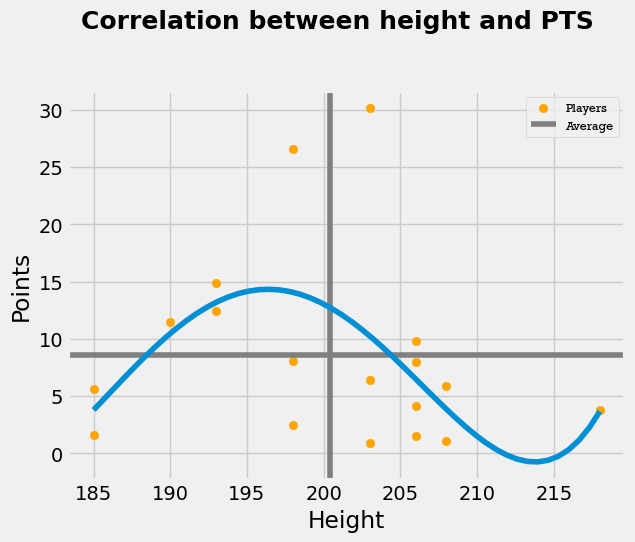

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the data
df = pd.read_csv(f'csv_files/{tid[0]}/{tid[1]}/stats.csv')

# Convert the 'PTS' column to float
df['PTS'] = df['PTS'].astype(float)

# Create the plots
heightPlotPTS, ax = plt.subplots()

ax.scatter(df['Height'], df['PTS'], label = "Players", color = 'orange')
ax.axvline(x = np.mean(df['Height']), color = 'grey')
ax.axhline(y = np.mean(df['PTS']), label = "Average", color = 'grey')
heightPlotPTS.suptitle("Correlation between height and PTS", weight = 'bold', size = 18, y = 1.05)
ax.set_xlabel("Height")
ax.set_ylabel("Points")

# Fit a polynomial of degree 4
z = np.polyfit(df['Height'], df['PTS'], 4)
f = np.poly1d(z)

x_new = np.linspace(min(df['Height']), max(df['Height']), 50)
y_new = f(x_new)
ax.plot(x_new, y_new)

ax.legend(loc='best', prop={'size': 9, 'family': 'Rockwell'})

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(df['Height'], df['PTS'])
print("Height and PTS: slope =", slope, ", intercept =", intercept, ", r_value =", r_value,
    ", p_value =", p_value, ", std_err =", std_err)
rpString = "r = " + str(round(r_value, 3)) + ", p = " + str(round(p_value, 3))


# Save the figure
heightPlotPTS.savefig(f'Photos/{tid[0]}/{tid[1]}/height-pts-exponential.png', dpi = 400, bbox_inches = 'tight')

Weight and PTS: slope = -0.12499809523809524 , intercept = 21.438041904761903 , r_value = -0.23798434204267233 , p_value = 0.3576734588170716 , std_err = 0.13171914565882764


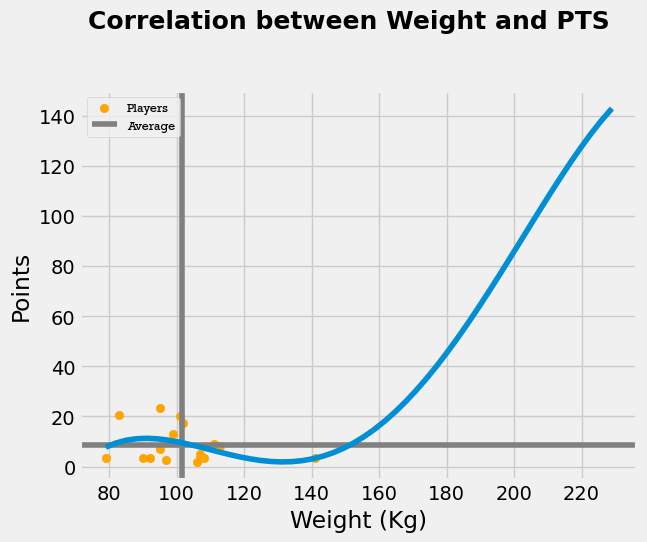

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the data
df = pd.read_csv(f'csv_files/{tid[0]}/{tid[1]}/stats.csv')

# Convert the 'PTS' column to float
df['PTS'] = df['PTS'].astype(float)

# Create the plots
heightPlotPTS, ax = plt.subplots()

ax.scatter(df['Weight (Kg)'], df['PTS'], label = "Players", color = 'orange')
ax.axvline(x = np.mean(df['Weight (Kg)']), color = 'grey')
ax.axhline(y = np.mean(df['PTS']), label = "Average", color = 'grey')
heightPlotPTS.suptitle("Correlation between Weight and PTS", weight = 'bold', size = 18, y = 1.05)
ax.set_xlabel("Weight (Kg)")
ax.set_ylabel("Points")

# Fit a polynomial of degree 4
z = np.polyfit(df['Weight (Kg)'], df['PTS'], 4)
f = np.poly1d(z)

x_new = np.linspace(min(df['Weight (Kg)']), max(df['Height']), 50)
y_new = f(x_new)
ax.plot(x_new, y_new)

ax.legend(loc='best', prop={'size': 9, 'family': 'Rockwell'})

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(df['Weight (Kg)'], df['PTS'])
print("Weight and PTS: slope =", slope, ", intercept =", intercept, ", r_value =", r_value,
    ", p_value =", p_value, ", std_err =", std_err)
rpString = "r = " + str(round(r_value, 3)) + ", p = " + str(round(p_value, 3))


# Save the figure
heightPlotPTS.savefig(f'Photos/{tid[0]}/{tid[1]}/weight-pts-exponential.png', dpi = 400, bbox_inches = 'tight')